## Imports

In [6]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from kerasAC.splits import *
from viz_preprocess import *
from viz_sequence import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

np.random.seed(1234)
plt.style.use('default')

## Prepare Reference Alleles

In [7]:
cluster = '24'
fold = '3'
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/gkmSVM/Cluster'+cluster+'/fold'+fold+'/test/gwas.pos.bed', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_ref = gwas_bed[4].tolist()
gwas_alt = gwas_bed[5].tolist()

ref_fasta = '/mnt/lab_data3/soumyak/adpd/gkmSVM/Cluster'+cluster+'/fold'+fold+'/test/ref.pos.fasta'
ref_hyp_file = '/mnt/lab_data3/soumyak/adpd/gkmSVM/Cluster'+cluster+'/fold'+fold+'/explain/output/ref_hyp_scores.txt'

ref_seqs = [x.rstrip() for (i,x) in enumerate(open(ref_fasta)) if i%2==1]
ref_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in ref_seqs if ('N' not in x)]

print("Num onehot sequences:", len(ref_onehot))

ref_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(ref_hyp_file)], ref_seqs) if 'N' not in w[1]]

ref_imp_scores = get_impscores(ref_hyp_scores, ref_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(ref_imp_scores,
                                 ref_onehot,
                                 ref_hyp_scores)])) == 0

ref_normed_imp_scores, ref_normed_hyp_scores = normalize_scores(
    impscores=ref_imp_scores, hyp_impscores=ref_hyp_scores, onehot_data=ref_onehot)

Num onehot sequences: 863


## Prepare Alternate Alleles

In [8]:
alt_fasta = '/mnt/lab_data3/soumyak/adpd/gkmSVM/Cluster'+cluster+'/fold'+fold+'/test/alt.pos.fasta'
alt_hyp_file = '/mnt/lab_data3/soumyak/adpd/gkmSVM/Cluster'+cluster+'/fold'+fold+'/explain/output/alt_hyp_scores.txt'
                                                                                
alt_seqs = [x.rstrip() for (i,x) in enumerate(open(alt_fasta)) if i%2==1]       
alt_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in alt_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(alt_onehot))                                 
                                                                                
alt_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(alt_hyp_file)], alt_seqs) if 'N' not in w[1]]                 
                                                                                
alt_imp_scores = get_impscores(alt_hyp_scores, alt_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(alt_imp_scores,                                
                                 alt_onehot,                                    
                                 alt_hyp_scores)])) == 0                        
                                                                                
alt_normed_imp_scores, alt_normed_hyp_scores = normalize_scores(                
    impscores=alt_imp_scores, hyp_impscores=alt_hyp_scores, onehot_data=alt_onehot)

Num onehot sequences: 863


## Find Alternate Alleles that Break Accessibility

In [9]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'ref_score':[], 'alt_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['ref_score'].append(np.sum(ref_imp_scores[i][400:600]))
    seq_dict['alt_score'].append(np.sum(alt_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(alt_imp_scores[i][400:600]) - np.sum(ref_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head()

,index,chr,start,end,ref_score,alt_score,delta
123,123,chr6,32654501,32654502,1.311882,0.352924,-0.958958
570,570,chr6,47542863,47542864,1.177736,0.337286,-0.840450
106,106,chr6,32676158,32676159,0.235085,-0.465683,-0.700768
624,624,chr6,32551328,32551329,1.165722,0.625295,-0.540427
643,643,chr6,32573779,32573780,0.794780,0.260355,-0.534425


In [10]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(ref_seq.fetch(gwas_chrom[idx], gwas_end[idx] - 10, gwas_end[idx] + 10))

actatggaaagtgaaaccat
GAACTTCCACTTTCTATCCT
tttaaagttccccttgatca
GTCTACTCAGTTCCTCTAGA
atgctgctgaatcagttgta


## Visualize Top Sequences

Index:  123  Importance:  1.3118818286000002  RSID:  rs9275183   chr6 : 32654501 - 32654502
Reference Allele:  A


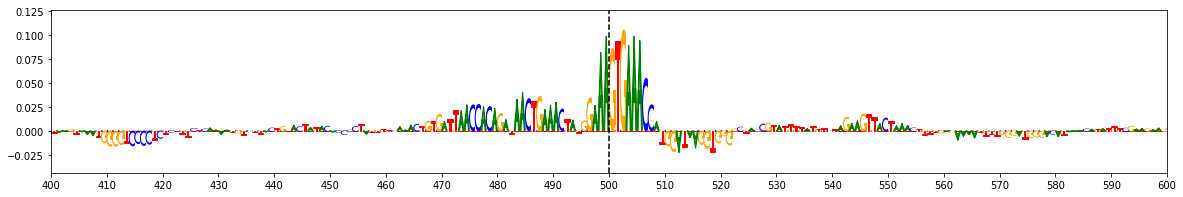

Index:  123  Importance:  0.35292407550000005  RSID:  rs9275183
Alternate Allele:  G


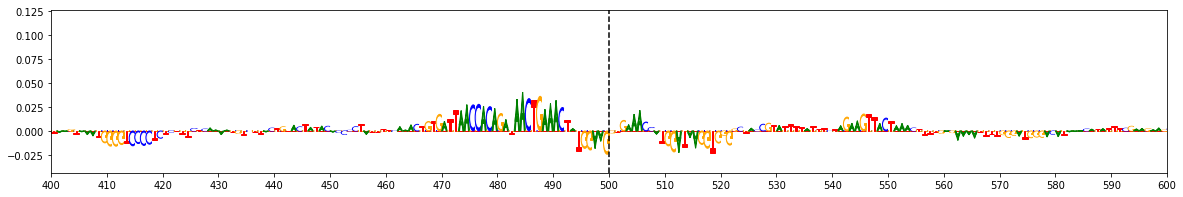

Index:  123  Delta:  -0.9589577531000002  RSID:  rs9275183
Alt - Ref:  G - A


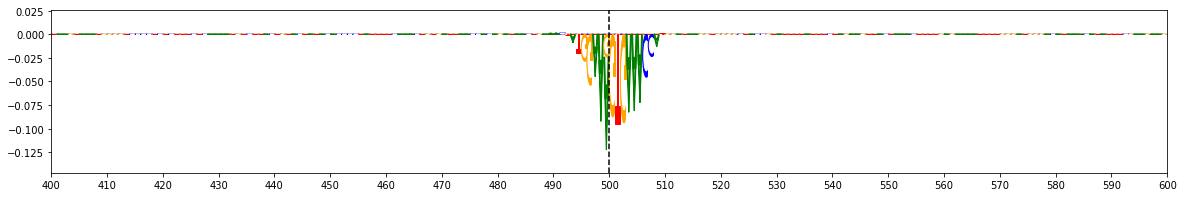

Index:  570  Importance:  1.1777364736  RSID:  rs9395279   chr6 : 47542863 - 47542864
Reference Allele:  C


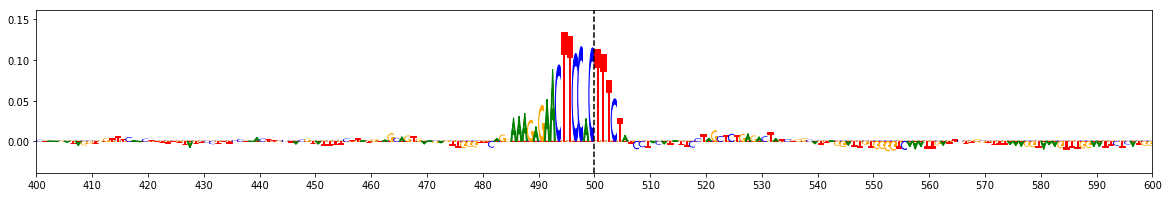

Index:  570  Importance:  0.3372864618000001  RSID:  rs9395279
Alternate Allele:  T


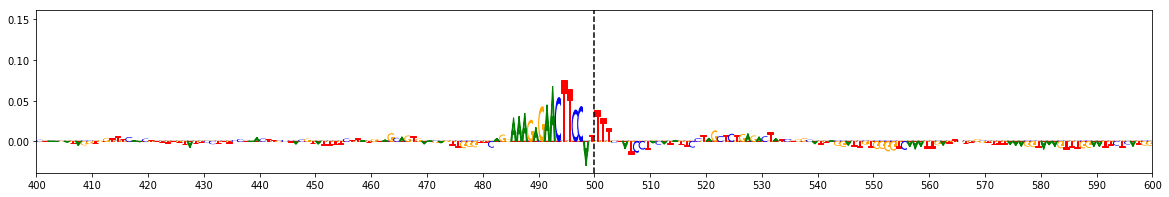

Index:  570  Delta:  -0.8404500117999999  RSID:  rs9395279
Alt - Ref:  T - C


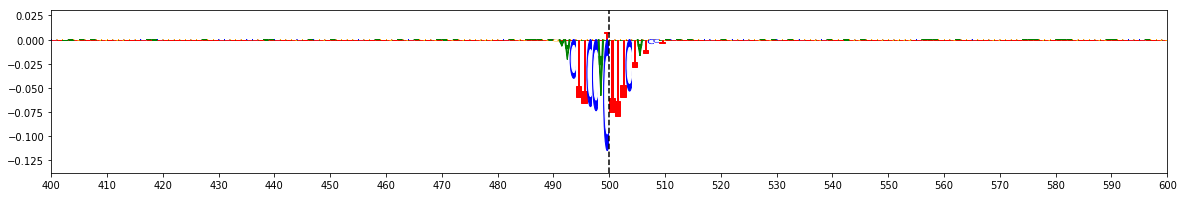

Index:  106  Importance:  0.23508485029999998  RSID:  rs9275541   chr6 : 32676158 - 32676159
Reference Allele:  C


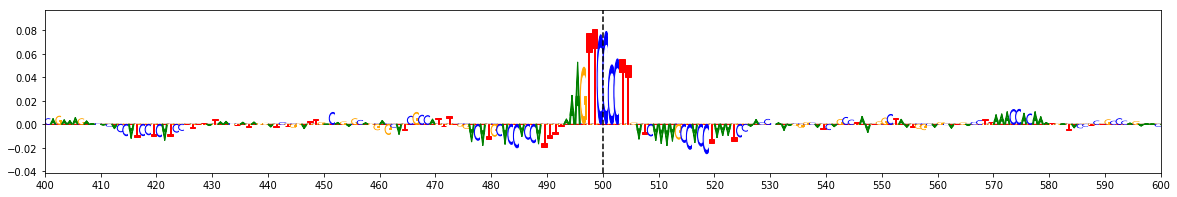

Index:  106  Importance:  -0.465682931  RSID:  rs9275541
Alternate Allele:  G


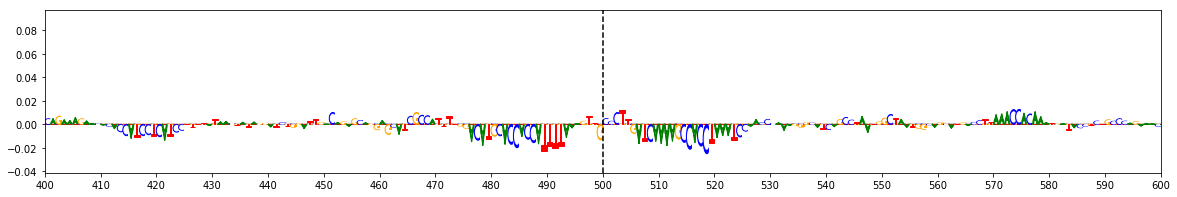

Index:  106  Delta:  -0.7007677813  RSID:  rs9275541
Alt - Ref:  G - C


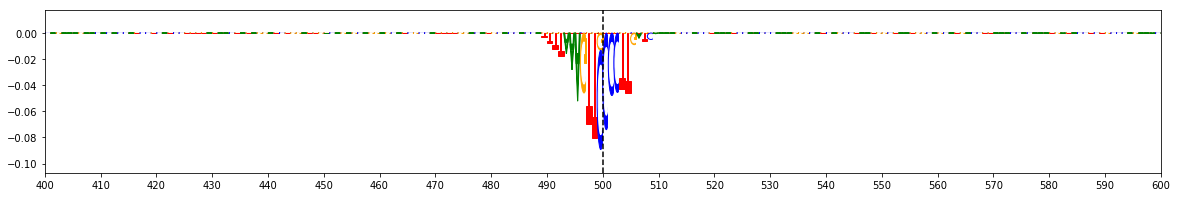

Index:  624  Importance:  1.1657218132  RSID:  rs9269908   chr6 : 32551328 - 32551329
Reference Allele:  G


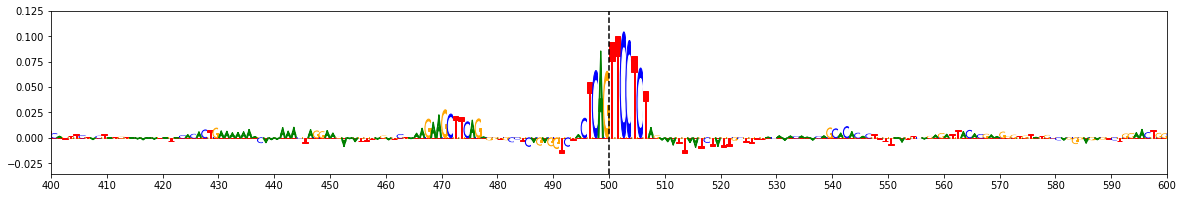

Index:  624  Importance:  0.6252945366  RSID:  rs9269908
Alternate Allele:  A


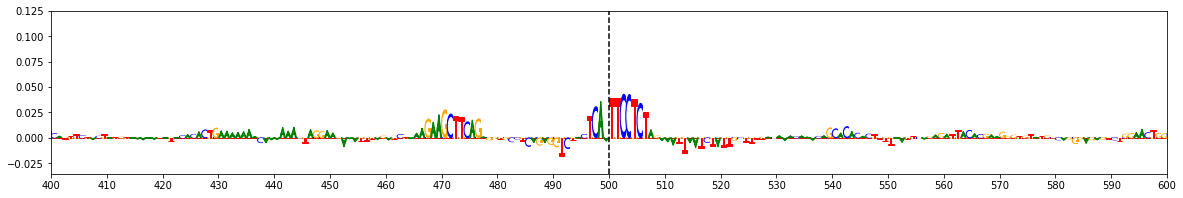

Index:  624  Delta:  -0.5404272766  RSID:  rs9269908
Alt - Ref:  A - G


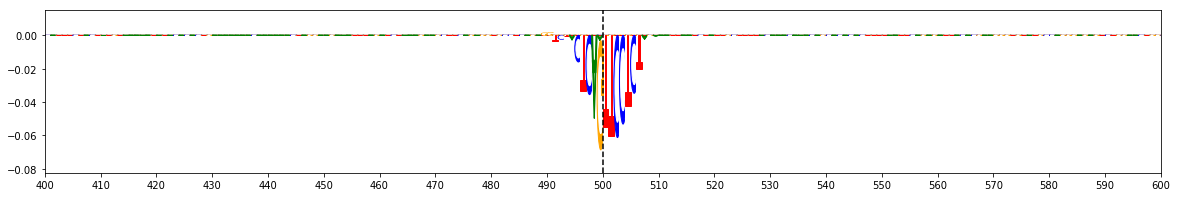

Index:  643  Importance:  0.7947795730000001  RSID:  rs9270979   chr6 : 32573779 - 32573780
Reference Allele:  A


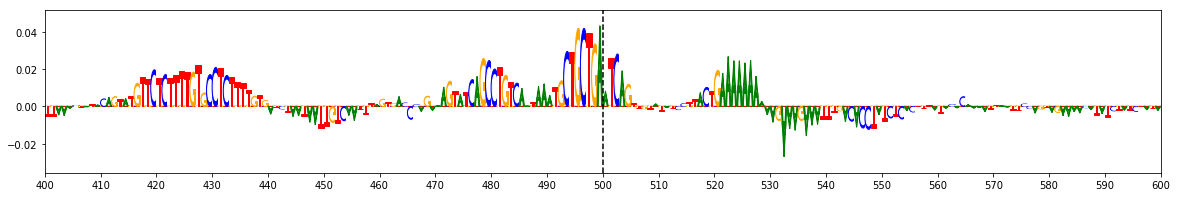

Index:  643  Importance:  0.26035459871  RSID:  rs9270979
Alternate Allele:  G


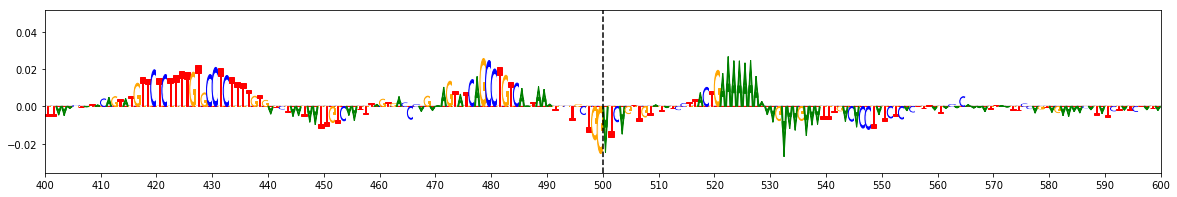

Index:  643  Delta:  -0.5344249742900001  RSID:  rs9270979
Alt - Ref:  G - A


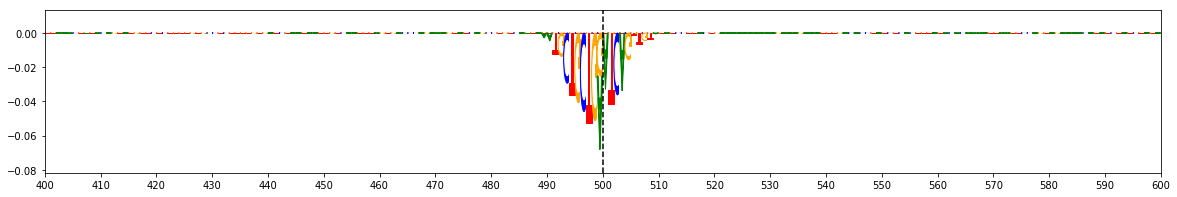

In [5]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'ref_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'])
    print("Reference Allele: ", gwas_ref[idx])
    ylim = plot_weights(ref_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'alt_score'], " RSID: ", gwas_rsid[idx])
    print("Alternate Allele: ", gwas_alt[idx])
    a = plot_weights(alt_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Alt - Ref: ", gwas_alt[idx] + ' - ' + gwas_ref[idx])
    a = plot_weights(alt_imp_scores[idx] - ref_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [6]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head()

,index,chr,start,end,ref_score,alt_score,delta
695,695,chr6,32578672,32578673,-0.156058,1.182492,1.338550
2,2,chr6,47397745,47397746,0.205111,1.043948,0.838836
191,191,chr6,32558568,32558569,0.977101,1.791661,0.814559
589,589,chr6,32578229,32578230,-0.111422,0.668409,0.779832
550,550,chr6,47494758,47494759,-0.133718,0.629051,0.762769


## Visualize Top Sequences

Index:  695  Importance:  -0.15605810470000003  RSID:  rs7451864 chr6 :  32578672  -  32578673
Alternate Allele:  C


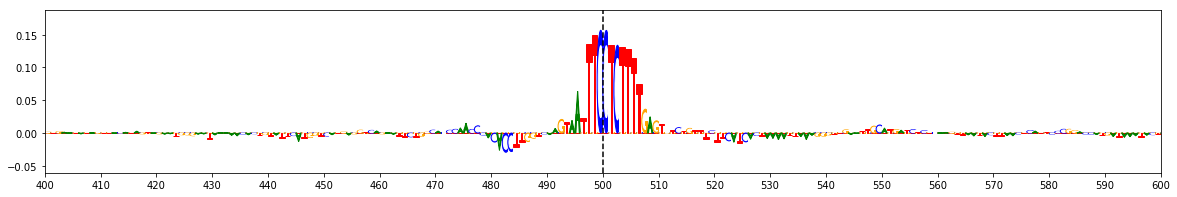

Index:  695  Importance:  -0.15605810470000003  RSID:  rs7451864
Reference Allele:  A


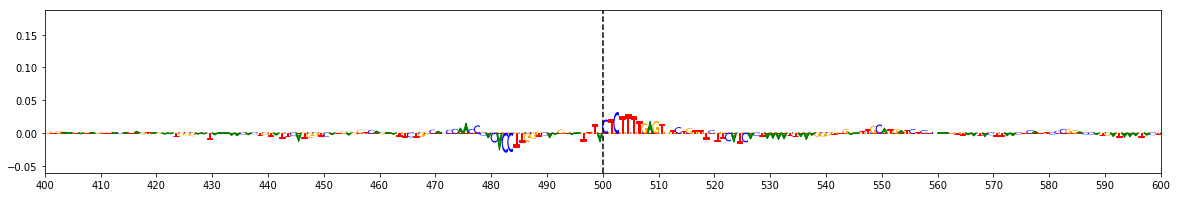

Index:  695  Delta:  1.3385497232999999  RSID:  rs7451864
Alt - Ref:  C - A


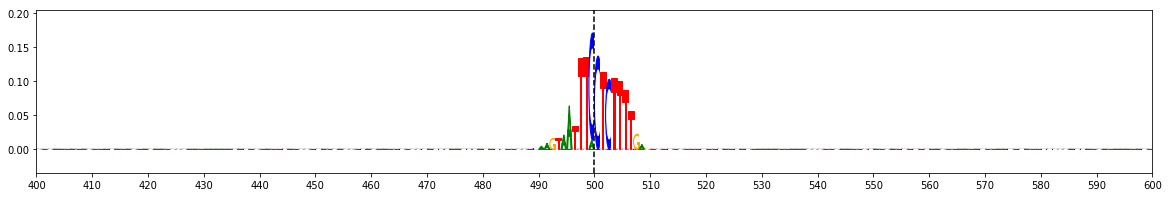

Index:  2  Importance:  0.20511125229999994  RSID:  rs2184397 chr6 :  47397745  -  47397746
Alternate Allele:  A


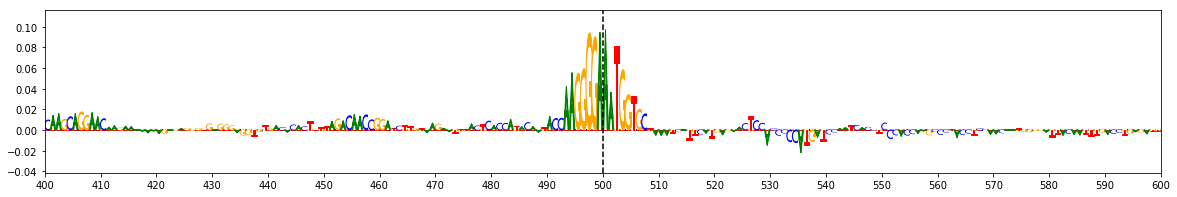

Index:  2  Importance:  0.20511125229999994  RSID:  rs2184397
Reference Allele:  G


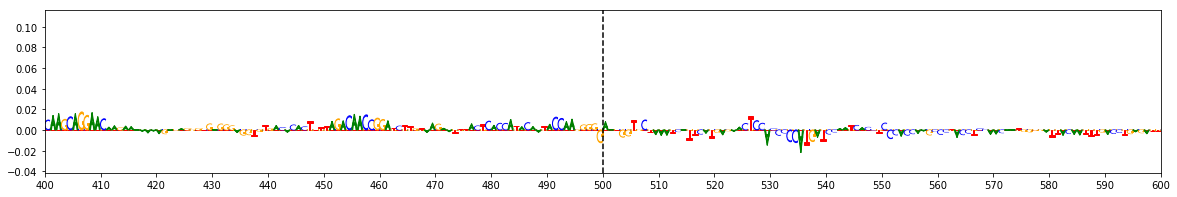

Index:  2  Delta:  0.8388363497000001  RSID:  rs2184397
Alt - Ref:  A - G


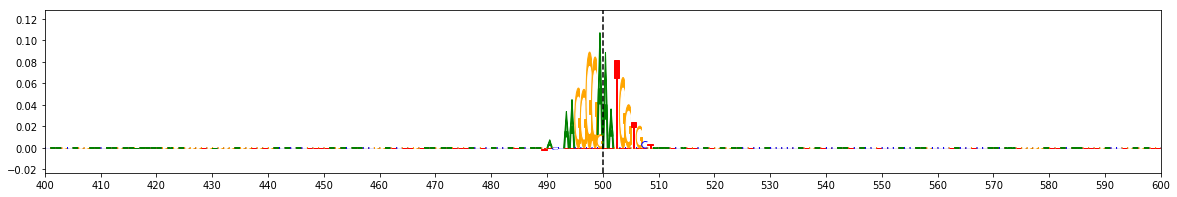

Index:  191  Importance:  0.9771014149499999  RSID:  rs9270420 chr6 :  32558568  -  32558569
Alternate Allele:  T


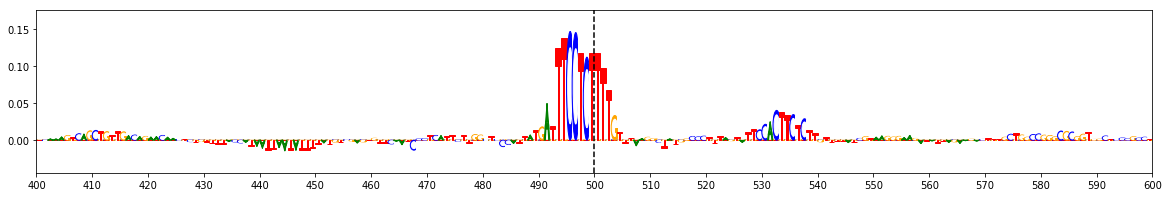

Index:  191  Importance:  0.9771014149499999  RSID:  rs9270420
Reference Allele:  C


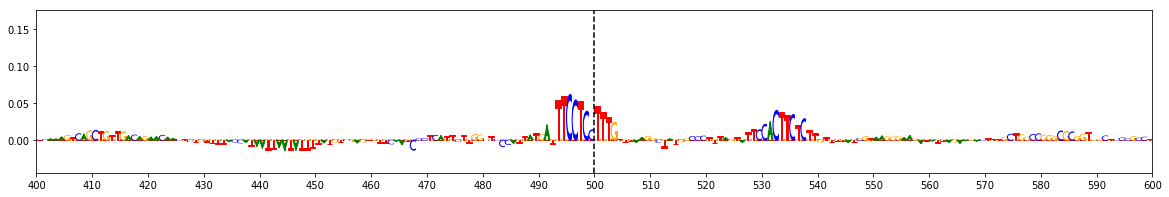

Index:  191  Delta:  0.8145591348200001  RSID:  rs9270420
Alt - Ref:  T - C


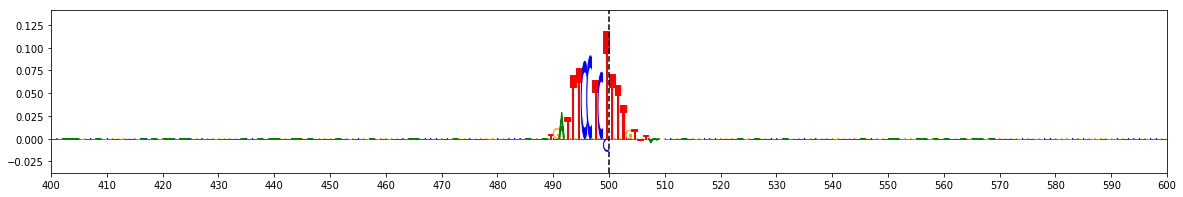

Index:  589  Importance:  -0.11142246330000005  RSID:  rs9271182 chr6 :  32578229  -  32578230
Alternate Allele:  G


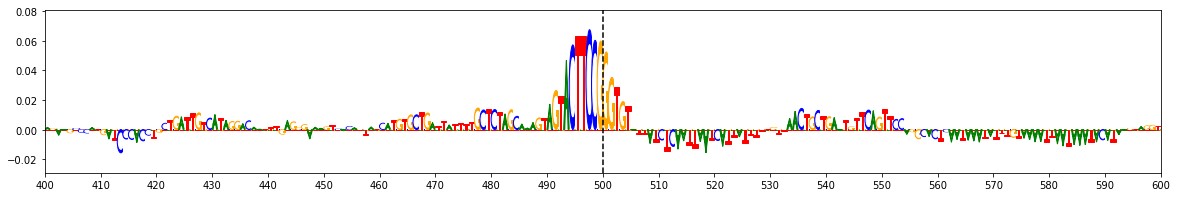

Index:  589  Importance:  -0.11142246330000005  RSID:  rs9271182
Reference Allele:  A


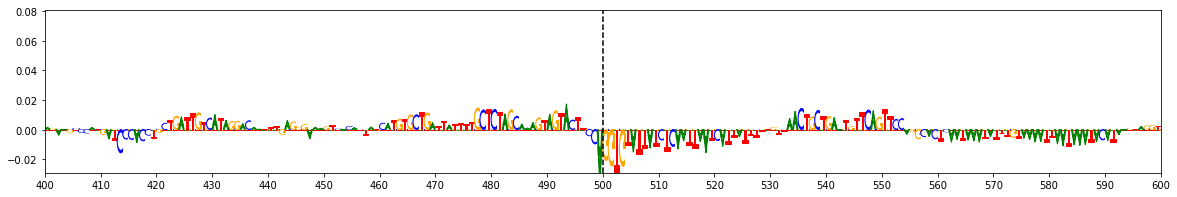

Index:  589  Delta:  0.7798317197  RSID:  rs9271182
Alt - Ref:  G - A


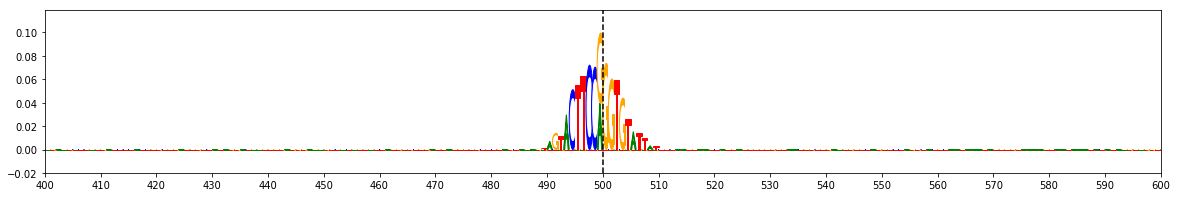

Index:  550  Importance:  -0.1337183191  RSID:  rs9296564 chr6 :  47494758  -  47494759
Alternate Allele:  G


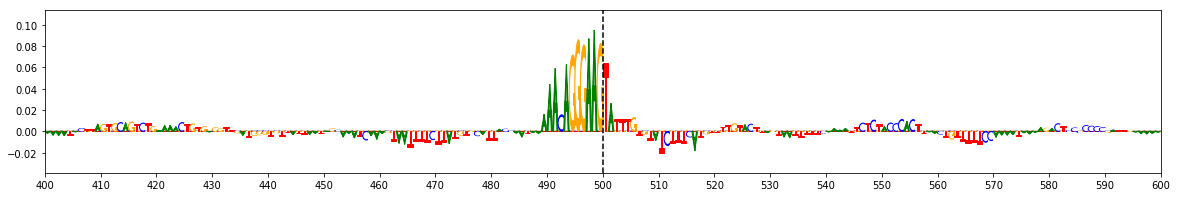

Index:  550  Importance:  -0.1337183191  RSID:  rs9296564
Reference Allele:  A


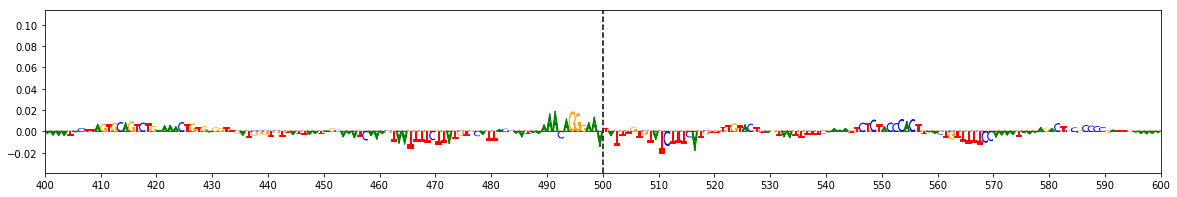

Index:  550  Delta:  0.7627689915999999  RSID:  rs9296564
Alt - Ref:  G - A


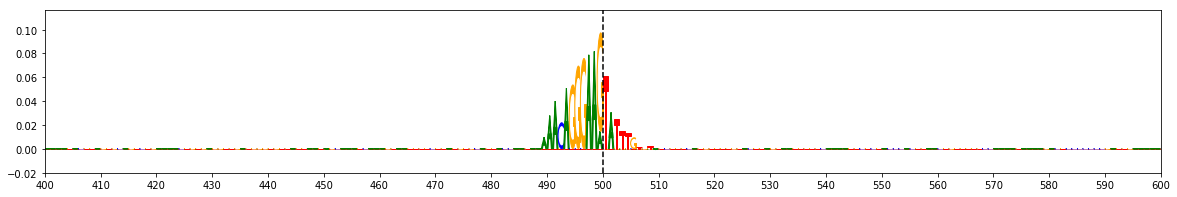

In [7]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'ref_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'])
    print("Alternate Allele: ", gwas_alt[idx])
    ylim = plot_weights(alt_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'ref_score'], " RSID: ", gwas_rsid[idx])
    print("Reference Allele: ", gwas_ref[idx])
    a = plot_weights(ref_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Alt - Ref: ", gwas_alt[idx] + ' - ' + gwas_ref[idx])
    a = plot_weights(alt_imp_scores[idx] - ref_imp_scores[idx], subticks_frequency=10, xlim=(400,600))